##Домашнее задание

Light
1. Зарегистрируйтесь на закрытое соревнование на Kaggle по ссылке - https://www.kaggle.com/t/24b564ae7bb94ecba14039da1933ed4f

Примите условия участия в соревновании.

2. Используйте шаблон ноутбука, чтобы отправить решение на Kaggle - https://colab.research.google.com/drive/14qSjZOTB_ZH-xp8E3ar6v_SmCvyIBAeJ

3. Попробуйте изменить нейронную сеть, чтобы улучшить качество решения:

Изменяйте количество полносвязных слоев и нейронов в них
Используйте слой Embedding
Попробуйте использовать Dropout или другие методы регуляризации
Изменяйте количество эпох обучения
Изменяйте размер мини-выборки (batch_size)
4. Во время обучения следите, чтобы не возникло переобучения.

5. После подбора лучших гиперпараметров, обучите сеть еще раз на полном объеме данных без разделения на обучающий и проверочный наборы.

6. Составьте отчет, который включает:

Место в соревновании, которое вам удалось достичь
Описание архитектуры нейронной сети и гиперпараметров обучения
Ссылку на ноутбук с кодом обучения
График качества обучения на обучающем и проверочном наборах данных

Pro

Усложненный вариант домашнего задания

Обучите нейронную сеть определять Кибер-троллей по сообщения в твиттер. Набор данных:

https://dataturks.com/projects/abhishek.narayanan/Dataset%20for%20Detection%20of%20Cyber-Trolls

In [1]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, Activation, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM, BatchNormalization, SimpleRNN
from tensorflow.keras import utils
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau,LearningRateScheduler
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import random, math
%matplotlib inline 

Using TensorFlow backend.


#Настраиваем Kaggle API

In [3]:

!mkdir ~/.kaggle
!cp /content/drive/My\ Drive/kaggle.json ~/.kaggle
!ls ~/.kaggle

#Загружаем данные с сайта Kaggle

!kaggle competitions download -c neural-university-reuters-spring2019


mkdir: cannot create directory ‘/root/.kaggle’: File exists
kaggle.json
  0% 0.00/1.73M [00:00<?, ?B/s]
100% 1.73M/1.73M [00:00<00:00, 50.6MB/s]
  0% 0.00/16.5k [00:00<?, ?B/s]
100% 16.5k/16.5k [00:00<00:00, 29.7MB/s]
  0% 0.00/785k [00:00<?, ?B/s]
100% 785k/785k [00:00<00:00, 136MB/s]


In [4]:
!unzip train.npz.zip

Archive:  train.npz.zip
  inflating: train.npz               


#base line

In [0]:
num_words=10000

data = np.load('train.npz', allow_pickle=True) 
x_train = data['x'] 
y_train = data['y']

x_test = np.load('test.npy', allow_pickle=True)

In [6]:
word_index = reuters.get_word_index()
index_word = {v: k for k, v in word_index.items()}

text = ''
for x in x_train[0]:
  text += ' '+index_word.get(x-3,'?')
text 

557056/550378 [==============================] - 0s 0us/step


' ? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

## Подготовка данных для нейронной сети

In [0]:
tokenizer = Tokenizer(num_words=num_words)

x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')

y_train = utils.to_categorical(y_train)

In [0]:
x_train.shape

(8982, 10000)

## Модель нейронной сети

In [0]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(num_words,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(46, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, 
                    y_train, 
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1)

W0615 07:34:48.147670 139941562632064 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 8083 samples, validate on 899 samples
Epoch 1/10
8083/8083 [==============================] - 2s 264us/sample - loss: 1.5528 - acc: 0.6698 - val_loss: 1.1255 - val_acc: 0.7486
Epoch 2/10
8083/8083 [==============================] - 1s 154us/sample - loss: 0.6512 - acc: 0.8534 - val_loss: 0.9405 - val_acc: 0.7931
Epoch 3/10
8083/8083 [==============================] - 1s 151us/sample - loss: 0.3424 - acc: 0.9243 - val_loss: 0.9425 - val_acc: 0.8020
Epoch 4/10
8083/8083 [==============================] - 1s 150us/sample - loss: 0.2288 - acc: 0.9474 - val_loss: 0.9735 - val_acc: 0.8042
Epoch 5/10
8083/8083 [==============================] - 1s 149us/sample - loss: 0.1789 - acc: 0.9526 - val_loss: 1.0439 - val_acc: 0.7887
Epoch 6/10
8083/8083 [==============================] - 1s 147us/sample - loss: 0.1582 - acc: 0.9571 - val_loss: 1.0257 - val_acc: 0.8031
Epoch 7/10
8083/8083 [==============================] - 1s 148us/sample - loss: 0.1460 - acc: 0.9557 - val_loss: 1.0877 - val

0.80422693


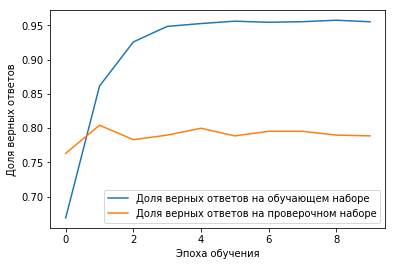

In [0]:
print(np.max(history.history['val_acc']))
plt.plot(history.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

#mod base line

In [0]:
num_words=10000
weight_decay = .0005

model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(num_words,), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.8))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
#model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(46, activation='softmax'))

  
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

сheckpoint = ModelCheckpoint('nlp.hfd5', monitor='val_acc', save_best_only=True, verbose=0)
def step_decay(epoch):
  initial_lrate = .001
  drop = 0.8
  epochs_drop = 5.0
  lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
  #lrate = lrate if lrate > 5e-4 else 5e-4
  return lrate    

#lrate = LearningRateScheduler (step_decay,verbose=0)
lrate = ReduceLROnPlateau(monitor='val_acc', factor=0.7, patience=3, min_lr=1e-5, verbose=0)

history = model.fit(x_train, 
                    y_train, 
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[сheckpoint,lrate])



Train on 7185 samples, validate on 1797 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
7185/7185 [==============================] - 3s 432us/sample - loss: 2.2467 - acc: 0.5609 - val_loss: 1.6568 - val_acc: 0.7295
Epoch 2/100
7185/7185 [==============================] - 2s 261us/sample - loss: 1.5954 - acc: 0.6926 - val_loss: 1.3517 - val_acc: 0.7674
Epoch 3/100
7185/7185 [==============================] - 2s 264us/sample - loss: 1.4495 - acc: 0.7383 - val_loss: 1.3125 - val_acc: 0.7902
Epoch 4/100
7185/7185 [==============================] - 2s 259us/sample - loss: 1.3416 - acc: 0.7717 - val_loss: 1.3128 - val_acc: 0.7991
Epoch 5/100
7185/7185 [==============================] - 2s 253us/sample - loss: 1.3115 - acc: 0.7779 - val_loss: 1.3317 - val_acc: 0.7991
Epoch 6/100
7185/7185 [==============================] - 2s 254us/sample - loss: 1.2274 - acc: 0.8046 - val_loss: 1.3386 - val_acc: 0.8114
Epoch 7/100
7185/7185 [==============================] - 2s 260us/samp

KeyboardInterrupt: ignored

In [0]:
model.load_weights('nlp.hfd5')
model.evaluate(x_train,y_train)

8982/8982 [==============================] - 2s 186us/sample - loss: 0.4897 - acc: 0.9424


[0.48973004952275495, 0.94244045]

0.8253615


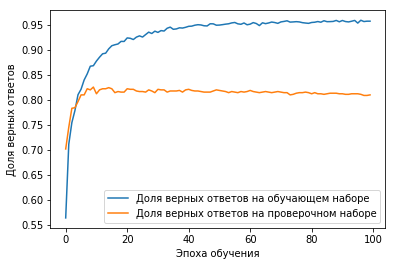

In [0]:
print(np.max(history.history['val_acc']))
plt.plot(history.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

ValueError: ignored

#Optimization

In [0]:
loss = 'acc'

def create_model(params):
  weight_decay = params['wd']

  model = Sequential()
  model.add(Dense(params['filters'], activation=params['activation'], input_shape=(num_words,), kernel_regularizer=regularizers.l2(weight_decay)))
  if params['bn'] == 1:
    model.add(BatchNormalization())
  model.add(Dropout(params['drop']))
  
  if params['layers'] == 2 or params['layers'] == 3:
    model.add(Dense(params['filters']*2, activation=params['activation'], kernel_regularizer=regularizers.l2(weight_decay)))  
    if params['bn'] == 1:
      model.add(BatchNormalization())
    model.add(Dropout(params['drop']))
  
  if params['layers'] == 3:
    model.add(Dense(params['filters']*3, activation=params['activation'], kernel_regularizer=regularizers.l2(weight_decay)))  
    if params['bn'] == 1:
      model.add(BatchNormalization())
    model.add(Dropout(params['drop']))

  model.add(Dense(46, activation='softmax'))

  model.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
  
#   opt = Adam(lr=1e-3, decay=1e-3 / 200)
#   model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])  
  return model

def optimization(f_create_model,space,max_evals = 30,test_size = .15,loss = loss,seed = 42):
  
  сheckpoint = ModelCheckpoint('nlp.hfd5', monitor='val_'+loss, save_best_only=True, verbose=0)
  earlystop = EarlyStopping(monitor='val_'+loss, min_delta=0.001, patience=10,verbose=0, mode='auto')

  def step_decay(epoch):
    initial_lrate = params['lr']
    drop = 0.95
    epochs_drop = 2.0
    lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
    return lrate    
  lrate = LearningRateScheduler (step_decay)  
  
  def space_eval_trial(space, trial):
      for_eval = {}
      for k, v in trial["misc"]["vals"].items():
          if len(v) == 0:
              for_eval[k] = None
          else:
              for_eval[k] = v[0]
      return space_eval(space, for_eval)
    
  #целевая функция минимизации (для поиска гиперпараметров)
  def objective(params):
    np.random.seed(seed)
    random.seed(seed)

    batch_size = params['batch_size']

    model = f_create_model(params)
    
    history = model.fit(x_train, 
                      y_train, 
                      epochs=15,
                      batch_size=params['batch_size'],
                      validation_split=0.1)
  
    err = -np.max(history.history['val_'+params['loss']])

    return {'loss': err, 'status': STATUS_OK}  
  
  
  trials = Trials()
  best = fmin(objective, space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
  
  res = []
  for trial in sorted(trials, key=lambda x: x['result']['loss'], reverse=False):
    res.append([-trial['result']['loss'],space_eval_trial(space, trial)])
    
  
  return res

space = {'filters' : hp.choice('filters', [4,8,16,32]),         
         'batch_size' : hp.choice('batch_size', [32,64]),
         'wd' : hp.choice('wd', [.01,.001,.005,.0001,.0005]),
         'drop' : hp.choice('drop', [.1,.2,.3,.4,.5,.6,.7,.8]),
         'activation' : hp.choice('activation', ['relu','elu']),
         'layers': hp.choice('layers', [1,2,3]),
         'bn': hp.choice('bn', [0,1]),
         'loss' : loss
         }

res = optimization(create_model,space,max_evals=15)

In [0]:
res

[[0.8086763024330139,
  {'activation': 'elu',
   'batch_size': 64,
   'bn': 1,
   'drop': 0.1,
   'filters': 32,
   'layers': 2,
   'loss': 'acc',
   'wd': 0.0005}],
 [0.7986651659011841,
  {'activation': 'relu',
   'batch_size': 64,
   'bn': 0,
   'drop': 0.3,
   'filters': 32,
   'layers': 1,
   'loss': 'acc',
   'wd': 0.001}],
 [0.7842046618461609,
  {'activation': 'elu',
   'batch_size': 32,
   'bn': 0,
   'drop': 0.4,
   'filters': 16,
   'layers': 2,
   'loss': 'acc',
   'wd': 0.0001}],
 [0.7630701065063477,
  {'activation': 'elu',
   'batch_size': 64,
   'bn': 1,
   'drop': 0.1,
   'filters': 8,
   'layers': 3,
   'loss': 'acc',
   'wd': 0.005}],
 [0.7241379022598267,
  {'activation': 'elu',
   'batch_size': 32,
   'bn': 1,
   'drop': 0.5,
   'filters': 16,
   'layers': 3,
   'loss': 'acc',
   'wd': 0.01}],
 [0.6829810738563538,
  {'activation': 'relu',
   'batch_size': 32,
   'bn': 1,
   'drop': 0.6,
   'filters': 16,
   'layers': 3,
   'loss': 'acc',
   'wd': 0.005}],
 [0.6095

In [0]:
seed = 42
np.random.seed(seed)
random.seed(seed)

params = {'activation': 'elu',
   'batch_size': 96,
   'bn': 0,
   'drop': 0.3,
   'filters': 64,
   'layers': 1,
   'loss': 'acc',
   'lr': .001,
   'wd': 0.0001 }

model = create_model(params)

opt = RMSprop()
model.compile(optimizer=opt, 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

сheckpoint = ModelCheckpoint('nlp.hfd5', monitor='val_'+loss, save_best_only=True, verbose=0)

def step_decay(epoch):
  initial_lrate = params['lr']
  drop = 0.8
  epochs_drop = 3.0
  lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
  return lrate    
lrate = LearningRateScheduler (step_decay) 

history = model.fit(x_train, 
                      y_train, 
                      epochs=100,
                      batch_size=params['batch_size'],
                      validation_split=0.1,
                      callbacks=[lrate,сheckpoint])
  



Train on 8083 samples, validate on 899 samples
Epoch 1/100
8083/8083 [==============================] - 5s 638us/sample - loss: 1.7306 - acc: 0.6373 - val_loss: 1.2609 - val_acc: 0.7341
Epoch 2/100
8083/8083 [==============================] - 1s 101us/sample - loss: 0.9571 - acc: 0.8035 - val_loss: 1.0438 - val_acc: 0.7820
Epoch 3/100
8083/8083 [==============================] - 1s 97us/sample - loss: 0.7038 - acc: 0.8587 - val_loss: 0.9753 - val_acc: 0.7887
Epoch 4/100
8083/8083 [==============================] - 1s 96us/sample - loss: 0.5804 - acc: 0.8898 - val_loss: 0.9402 - val_acc: 0.7964
Epoch 5/100
8083/8083 [==============================] - 1s 98us/sample - loss: 0.4940 - acc: 0.9057 - val_loss: 0.9116 - val_acc: 0.8087
Epoch 6/100
8083/8083 [==============================] - 1s 99us/sample - loss: 0.4212 - acc: 0.9208 - val_loss: 0.8988 - val_acc: 0.8176
Epoch 7/100
8083/8083 [==============================] - 1s 100us/sample - loss: 0.3777 - acc: 0.9291 - val_loss: 0.9021 - 

In [0]:
np.max(history.history['val_'+params['loss']])

0.8298109

#Готовим файл с решением для Kaggle

In [22]:
model.load_weights('nlp.hfd5') 
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)

out = np.column_stack((range(1, predictions.shape[0]+1), predictions))

np.savetxt('submission.csv', out, header="Id,Category", comments="", fmt="%d,%d")

!head submission.csv

#base 0.79875
#!kaggle competitions submit -c neural-university-reuters-spring2019 -m "Baseline submition from Colab" -f submission.csv

Id,Category
1,3
2,21
3,11
4,3
5,7
6,4
7,1
8,3
9,4


In [23]:
!kaggle competitions submit -c neural-university-reuters-spring2019 -m "Baseline submition from Colab" -f submission.csv

100% 15.0k/15.0k [00:05<00:00, 2.68kB/s]
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/kaggle/cli.py", line 64, in main
    print(out, end='')
UnicodeEncodeError: 'latin-1' codec can't encode characters in position 26-38: ordinal not in range(256)


#Simple RNN

In [0]:
embedding_dropout_factor = 0.3
recurrent_dropout_factor = 0.1
RNN_dropout_factor = 0.1
layer_dropout_factor = 0.1

model = Sequential()
model.add(Embedding(num_words, embedding_len, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Dropout(embedding_dropout_factor))

model.add(SimpleRNN(units=256, return_sequences=True,recurrent_dropout=recurrent_dropout_factor,dropout=RNN_dropout_factor))
model.add(Dropout(layer_dropout_factor))

model.add(SimpleRNN(units=256, recurrent_dropout=recurrent_dropout_factor, dropout=RNN_dropout_factor))
model.add(Dropout(layer_dropout_factor))
model.add(Dense(46, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


history = model.fit(x_train, 
                    y_train, 
                    epochs=30,
                    batch_size=64,
                    validation_split=0.1)


Train on 8083 samples, validate on 899 samples
Epoch 1/30
8083/8083 [==============================] - 108s 13ms/sample - loss: 2.6302 - acc: 0.3043 - val_loss: 2.5081 - val_acc: 0.3337
Epoch 2/30
8083/8083 [==============================] - 100s 12ms/sample - loss: 2.5200 - acc: 0.3298 - val_loss: 2.5812 - val_acc: 0.3315
Epoch 3/30
8083/8083 [==============================] - 102s 13ms/sample - loss: 2.5118 - acc: 0.3251 - val_loss: 2.5084 - val_acc: 0.3315
Epoch 4/30
7104/8083 [=========================>....] - ETA: 12s - loss: 2.5027 - acc: 0.3276

KeyboardInterrupt: ignored

#glove


In [7]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip  
  

--2019-06-19 10:36:26--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-06-19 10:36:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-06-19 10:36:27--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [0]:
def glove_embedings(embedding_len):
  from tqdm import tqdm
  import os, re, csv, math, codecs

  #load embeddings
  print('loading word embeddings...')
  embeddings_index = {}
  f = codecs.open('glove.6B.{}d.txt'.format(embedding_len), encoding='utf-8')
  for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  f.close()
  print('found %s word vectors' % len(embeddings_index))
  return embeddings_index
  

In [9]:
max_length = 768
embedding_len = 300
num_words = 20000

data = np.load('train.npz', allow_pickle=True) 
x_train = data['x'] 
y_train = data['y']

x_test = np.load('test.npy', allow_pickle=True)

x_train = pad_sequences(x_train, maxlen=max_length, padding='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post')
y_train = utils.to_categorical(y_train)

print(np.max([len(x[x>0]) for x in x_train]))

embeddings_index = glove_embedings(embedding_len)

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, embedding_len))
for i,word in index_word.items():
  #word = index_word.get(x-3,'?')
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None and i < num_words - 3:
    embedding_matrix[i + 3] = embedding_vector
    

print(embedding_matrix)
print(np.max([len(x[x>0]) for x in embedding_matrix]))


1172it [00:00, 11713.14it/s]

768
loading word embeddings...


400000it [00:41, 9589.32it/s]


found 400000 word vectors
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [-0.35802001 -0.35132     0.058043   ...  0.047706    0.096891
   0.60788   ]
 [-0.080563   -0.28872001 -0.044591   ...  0.00099251  0.59461999
  -0.038304  ]
 [ 0.32411     0.168      -0.24684    ... -0.066475   -0.19941001
   0.25694999]]
184


##CNN model

In [32]:
from tensorflow.keras import  regularizers, optimizers
loss = 'acc'
params = {'activation': 'elu', 'batch_size': 128, 'drop': 0.3, 'filters': 256, 'flatten': 0, 'loss': 'acc', 'lr': 0.005, 'lr_drop': 0.8, 'units': 256, 'wd': 0.005}


def create_model(params):
  model = Sequential()
  model.add(Embedding(num_words, embedding_len, weights=[embedding_matrix], input_length=max_length, trainable=False))
  model.add(Conv1D(params['filters'], 7, activation=params['activation'], padding='same', kernel_regularizer=regularizers.l2(params['wd'])))  
  model.add(MaxPooling1D(7))
  model.add(Dropout(params['drop']))
  model.add(Conv1D(params['filters'], 7, activation=params['activation'], padding='same', kernel_regularizer=regularizers.l2(params['wd'])))
  
  model.add(GlobalMaxPooling1D())
  
  model.add(Dropout(params['drop']))
  model.add(Dense(params['units'], activation=params['activation'], kernel_regularizer=regularizers.l2(params['wd'])))
  model.add(Dropout(params['drop']))
  model.add(Dense(46, activation='softmax'))  
  #model.add(Dense(46, activation='sigmoid'))  

  #adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
  model.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
  return model
сheckpoint = ModelCheckpoint('nlp.hfd5', monitor='val_'+loss, save_best_only=True, verbose=0)
earlystop = EarlyStopping(monitor='val_'+loss, min_delta=0.001, patience=10,verbose=0, mode='auto')

def step_decay(epoch):
  initial_lrate = params['lr']
  drop = params['lr_drop']
  epochs_drop = 3.0
  lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
  return lrate    
lrate = LearningRateScheduler (step_decay)  

model = create_model(params)
#model.load_weights('nlp.hfd5')
history = model.fit(x_train, 
                    y_train, 
                    epochs=50,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks=[lrate,сheckpoint])


Train on 8083 samples, validate on 899 samples
Epoch 1/50
8083/8083 [==============================] - 9s 1ms/sample - loss: 4.4776 - acc: 0.2502 - val_loss: 2.8413 - val_acc: 0.0590
Epoch 2/50
8083/8083 [==============================] - 6s 687us/sample - loss: 2.5816 - acc: 0.3604 - val_loss: 2.3279 - val_acc: 0.5996
Epoch 3/50
8083/8083 [==============================] - 6s 686us/sample - loss: 2.2723 - acc: 0.6469 - val_loss: 2.4014 - val_acc: 0.6140
Epoch 4/50
8083/8083 [==============================] - 6s 693us/sample - loss: 2.0563 - acc: 0.6947 - val_loss: 1.8835 - val_acc: 0.7141
Epoch 5/50
8083/8083 [==============================] - 6s 691us/sample - loss: 1.9249 - acc: 0.7138 - val_loss: 1.9100 - val_acc: 0.7208
Epoch 6/50
8083/8083 [==============================] - 5s 678us/sample - loss: 1.7372 - acc: 0.7424 - val_loss: 1.6629 - val_acc: 0.7286
Epoch 7/50
8083/8083 [==============================] - 6s 683us/sample - loss: 1.6572 - acc: 0.7449 - val_loss: 1.6352 - val_a

0.8231368


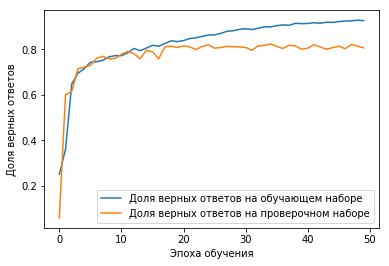

In [33]:
print(np.max(history.history['val_acc']))
plt.plot(history.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [0]:

seed = 42
def space_eval_trial(space, trial):
  for_eval = {}
  for k, v in trial["misc"]["vals"].items():
      if len(v) == 0:
          for_eval[k] = None
      else:
          for_eval[k] = v[0]
  return space_eval(space, for_eval)

#целевая функция минимизации (для поиска гиперпараметров)
def objective(params):
  np.random.seed(seed)
  random.seed(seed)

  сheckpoint = ModelCheckpoint('nlp.hfd5', monitor='val_'+loss, save_best_only=True, verbose=0)

  def step_decay(epoch):
    initial_lrate = params['lr']
    drop = params['lr_drop']
    epochs_drop = 2.0
    lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
    return lrate    
  lrate = LearningRateScheduler (step_decay)  


  batch_size = params['batch_size']

  model = create_model(params)

  history = model.fit(x_train, 
                    y_train, 
                    epochs=15,
                    batch_size=params['batch_size'],
                    validation_split=0.1,
                    callbacks=[lrate,сheckpoint])

  err = -np.max(history.history['val_'+params['loss']])

  return {'loss': err, 'status': STATUS_OK}  


space = {'filters' : hp.choice('filters', [128,256]),         
         'units' : hp.choice('units', [128,256]),         
         'batch_size' : hp.choice('batch_size', [64,128,256]),
         'wd' : hp.choice('wd', [.005,.0001,.0005]),
         'drop' : hp.choice('drop', [.2,.3,.4,.5]),
         'activation' : hp.choice('activation', ['relu','elu']),
         'flatten': hp.choice('bn', [0,1]),
         'lr': hp.choice('lr', [.01,.001,.0001]),
         'lr_drop': hp.choice('lr_drop', [.7,.8,.9]),
         'loss' : loss
         }

trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, trials=trials, max_evals=20)



 - ETA: 3s - loss: 1.2024 - acc: 0.8000

5120/8083 [==================>...........]
 - ETA: 3s - loss: 1.2040 - acc: 0.7996

5184/8083 [==================>...........]
 - ETA: 3s - loss: 1.2026 - acc: 0.7994

5248/8083 [==================>...........]
 - ETA: 3s - loss: 1.2016 - acc: 0.7999

5312/8083 [==================>...........]
 - ETA: 3s - loss: 1.2008 - acc: 0.7999

5376/8083 [==================>...........]
 - ETA: 3s - loss: 1.2017 - acc: 0.7997

5440/8083 [===================>..........]
 - ETA: 3s

In [0]:
for trial in sorted(trials, key=lambda x: x['result']['loss'], reverse=False):
  print([-trial['result']['loss'],space_eval_trial(space, trial)])
  
# [0.7808676362037659, {'activation': 'elu', 'batch_size': 128, 'drop': 0.4, 'filters': 128, 'flatten': 0, 'loss': 'acc', 'lr': 0.001, 'units': 256, 'wd': 0.0005}]
# [0.7652947902679443, {'activation': 'relu', 'batch_size': 256, 'drop': 0.4, 'filters': 128, 'flatten': 0, 'loss': 'acc', 'lr': 0.001, 'units': 256, 'wd': 0.0005}]
# [0.7619577050209045, {'activation': 'relu', 'batch_size': 64, 'drop': 0.7, 'filters': 512, 'flatten': 0, 'loss': 'acc', 'lr': 0.001, 'units': 128, 'wd': 0.005}]
# [0.7541713118553162, {'activation': 'elu', 'batch_size': 128, 'drop': 0.8, 'filters': 128, 'flatten': 1, 'loss': 'acc', 'lr': 0.001, 'units': 128, 'wd': 0.01}]
# [0.7530589699745178, {'activation': 'elu', 'batch_size': 64, 'drop': 0.4, 'filters': 256, 'flatten': 0, 'loss': 'acc', 'lr': 0.001, 'units': 512, 'wd': 0.01}]
# [0.7474972009658813, {'activation': 'relu', 'batch_size': 128, 'drop': 0.5, 'filters': 128, 'flatten': 1, 'loss': 'acc', 'lr': 0.001, 'units': 128, 'wd': 0.01}]
# [0.743047833442688, {'activation': 'relu', 'batch_size': 128, 'drop': 0.6, 'filters': 128, 'flatten': 0, 'loss': 'acc', 'lr': 0.001, 'units': 256, 'wd': 0.001}]
# [0.7419354915618896, {'activation': 'elu', 'batch_size': 256, 'drop': 0.6, 'filters': 256, 'flatten': 0, 'loss': 'acc', 'lr': 0.001, 'units': 256, 'wd': 0.0001}]
# [0.7374861240386963, {'activation': 'relu', 'batch_size': 64, 'drop': 0.7, 'filters': 512, 'flatten': 0, 'loss': 'acc', 'lr': 0.001, 'units': 256, 'wd': 0.01}]
# [0.7363737225532532, {'activation': 'elu', 'batch_size': 256, 'drop': 0.7, 'filters': 128, 'flatten': 1, 'loss': 'acc', 'lr': 0.001, 'units': 512, 'wd': 0.0001}]
# [0.7308120131492615, {'activation': 'relu', 'batch_size': 128, 'drop': 0.7, 'filters': 128, 'flatten': 0, 'loss': 'acc', 'lr': 0.001, 'units': 128, 'wd': 0.01}]
# [0.7230255603790283, {'activation': 'elu', 'batch_size': 64, 'drop': 0.4, 'filters': 256, 'flatten': 1, 'loss': 'acc', 'lr': 0.001, 'units': 512, 'wd': 0.0001}]
# [0.7230255603790283, {'activation': 'elu', 'batch_size': 64, 'drop': 0.6, 'filters': 128, 'flatten': 1, 'loss': 'acc', 'lr': 0.001, 'units': 512, 'wd': 0.01}]
# [0.6941045522689819, {'activation': 'relu', 'batch_size': 64, 'drop': 0.8, 'filters': 512, 'flatten': 0, 'loss': 'acc', 'lr': 0.001, 'units': 128, 'wd': 0.0001}]
# [0.6707452535629272, {'activation': 'elu', 'batch_size': 64, 'drop': 0.5, 'filters': 512, 'flatten': 1, 'loss': 'acc', 'lr': 0.001, 'units': 512, 'wd': 0.0001}]
# [0.5951056480407715, {'activation': 'elu', 'batch_size': 256, 'drop': 0.8, 'filters': 256, 'flatten': 0, 'loss': 'acc', 'lr': 0.001, 'units': 256, 'wd': 0.0005}]
# [0.5761957764625549, {'activation': 'elu', 'batch_size': 256, 'drop': 0.7, 'filters': 512, 'flatten': 1, 'loss': 'acc', 'lr': 0.001, 'units': 512, 'wd': 0.001}]
# [0.5739710927009583, {'activation': 'elu', 'batch_size': 128, 'drop': 0.7, 'filters': 512, 'flatten': 1, 'loss': 'acc', 'lr': 0.001, 'units': 128, 'wd': 0.0001}]
# [0.5583982467651367, {'activation': 'relu', 'batch_size': 256, 'drop': 0.7, 'filters': 128, 'flatten': 1, 'loss': 'acc', 'lr': 0.001, 'units': 512, 'wd': 0.01}]
  

[0.7975528240203857, {'activation': 'elu', 'batch_size': 128, 'drop': 0.3, 'filters': 256, 'flatten': 0, 'loss': 'acc', 'lr': 0.01, 'lr_drop': 0.7, 'units': 256, 'wd': 0.005}]
[0.7975528240203857, {'activation': 'elu', 'batch_size': 128, 'drop': 0.4, 'filters': 128, 'flatten': 0, 'loss': 'acc', 'lr': 0.001, 'lr_drop': 0.8, 'units': 256, 'wd': 0.0001}]
[0.788654088973999, {'activation': 'relu', 'batch_size': 256, 'drop': 0.2, 'filters': 256, 'flatten': 0, 'loss': 'acc', 'lr': 0.01, 'lr_drop': 0.9, 'units': 128, 'wd': 0.0001}]
[0.7719688415527344, {'activation': 'elu', 'batch_size': 64, 'drop': 0.4, 'filters': 128, 'flatten': 0, 'loss': 'acc', 'lr': 0.01, 'lr_drop': 0.8, 'units': 128, 'wd': 0.0005}]
[0.770856499671936, {'activation': 'elu', 'batch_size': 64, 'drop': 0.2, 'filters': 128, 'flatten': 1, 'loss': 'acc', 'lr': 0.001, 'lr_drop': 0.7, 'units': 128, 'wd': 0.005}]
[0.7630701065063477, {'activation': 'relu', 'batch_size': 256, 'drop': 0.3, 'filters': 256, 'flatten': 1, 'loss': 'acc

0.80978864


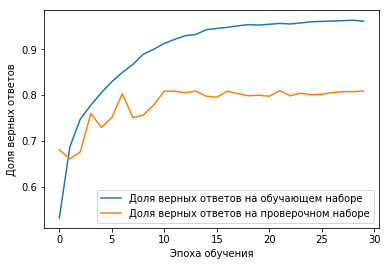

In [0]:
print(np.max(history.history['val_acc']))
plt.plot(history.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

#fast text

In [0]:
#!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.zip
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.simple.vec

--2019-06-15 08:38:44--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.simple.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.6.166, 104.20.22.166, 2606:4700:10::6814:6a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.6.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 293187541 (280M) [binary/octet-stream]
Saving to: ‘wiki.simple.vec’

wiki.simple.vec     100%[===================>] 279.60M  38.2MB/s    in 6.5s    

2019-06-15 08:38:50 (43.3 MB/s) - ‘wiki.simple.vec’ saved [293187541/293187541]



In [0]:
def fast_text_embedings():
  from tqdm import tqdm
  import os, re, csv, math, codecs

  #load embeddings
  print('loading word embeddings...')
  embeddings_index = {}
  f = codecs.open('wiki.simple.vec', encoding='utf-8')
  for line in tqdm(f):
      values = line.rstrip().rsplit(' ')
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
  f.close()
  print('found %s word vectors' % len(embeddings_index))
  return embeddings_index
  

In [0]:
max_length = 512
embedding_len = 300

data = np.load('train.npz', allow_pickle=True) 
x_train = data['x'] 
y_train = data['y']

x_test = np.load('test.npy', allow_pickle=True)

x_train = pad_sequences(x_train, maxlen=max_length, padding='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post')
y_train = utils.to_categorical(y_train)

print(np.max([len(x[x>0]) for x in x_train]))

embeddings_index = fast_text_embedings()

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, embedding_len))
for i,word in index_word.items():
  #word = index_word.get(x-3,'?')
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None and i < num_words - 3:
    embedding_matrix[i + 3] = embedding_vector
  
#   embedding_vector = embeddings_index.get(word)
#   if embedding_vector is not None and i < num_words:
#     embedding_matrix[i] = embedding_vector
    

print(embedding_matrix)
print(np.max([len(x[x>0]) for x in embedding_matrix]))


968it [00:00, 9675.86it/s]

512
loading word embeddings...


111052it [00:12, 8856.03it/s]


found 111052 word vectors
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.23976     0.52135003  0.30002001 ... -0.19840001 -0.30219001
  -0.17964999]
 [ 0.13387001 -0.29622999 -0.070298   ...  0.41510001 -0.1039
   0.26378   ]
 [-0.13901     0.056144   -0.49651    ... -0.07957    -0.20174
  -0.32416001]]
186


##CNN model

In [0]:
weight_decay = .005
filters = 512
units = 128
from tensorflow.keras import  regularizers, optimizers

model = Sequential()
model.add(Embedding(num_words, embedding_len, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Conv1D(filters, 7, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))
model.add(Conv1D(filters, 5, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))
model.add(Conv1D(filters, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(units, activation='relu'))#, kernel_regularizer=regularizers.l2(weight_decay)))
#model.add(Dense(units, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(46, activation='softmax'))  

сheckpoint = ModelCheckpoint('nlp.hfd5', monitor='val_'+loss, save_best_only=True, verbose=0)
earlystop = EarlyStopping(monitor='val_'+loss, min_delta=0.001, patience=10,verbose=0, mode='auto')

def step_decay(epoch):
  initial_lrate = .001
  drop = 0.7
  epochs_drop = 3.0
  lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
  return lrate    
lrate = LearningRateScheduler (step_decay)  

#adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=RMSprop(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, 
                    y_train, 
                    epochs=50,
                    batch_size=64,
                    validation_split=0.1,
                    callbacks=[сheckpoint,lrate])


Train on 8083 samples, validate on 899 samples
Epoch 1/50
8083/8083 [==============================] - 26s 3ms/sample - loss: 3.0367 - acc: 0.4027 - val_loss: 3.1151 - val_acc: 0.3804
Epoch 2/50
8083/8083 [==============================] - 14s 2ms/sample - loss: 2.1115 - acc: 0.5043 - val_loss: 2.4833 - val_acc: 0.4883
Epoch 3/50
8083/8083 [==============================] - 14s 2ms/sample - loss: 1.8747 - acc: 0.5474 - val_loss: 1.7489 - val_acc: 0.5762
Epoch 4/50
8083/8083 [==============================] - 14s 2ms/sample - loss: 1.7952 - acc: 0.5738 - val_loss: 2.1109 - val_acc: 0.4383
Epoch 5/50
8083/8083 [==============================] - 14s 2ms/sample - loss: 1.6857 - acc: 0.5979 - val_loss: 1.9073 - val_acc: 0.5384
Epoch 6/50
8083/8083 [==============================] - 14s 2ms/sample - loss: 1.6089 - acc: 0.6227 - val_loss: 1.5958 - val_acc: 0.6574
Epoch 7/50
8083/8083 [==============================] - 14s 2ms/sample - loss: 1.5132 - acc: 0.6449 - val_loss: 1.5350 - val_acc: 0

0.7208009


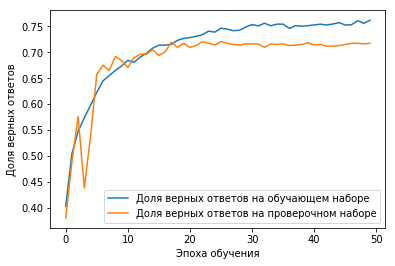

In [0]:
print(np.max(history.history['val_acc']))
plt.plot(history.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

##LSTM model

In [0]:
model = Sequential()
model.add(Embedding(num_words, embedding_len, weights=[embedding_matrix], input_length=max_length, trainable=False))
#model.add(Embedding(num_words, embedding_dim, input_length=maxlen))
model.add(LSTM(256))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(46, activation='softmax'))

model.compile(optimizer=RMSprop(lr=.01), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

сheckpoint = ModelCheckpoint('nlp.hfd5', monitor='val_'+loss, save_best_only=True, verbose=0)
earlystop = EarlyStopping(monitor='val_'+loss, min_delta=0.001, patience=10,verbose=0, mode='auto')

def step_decay(epoch):
  initial_lrate = .001
  drop = 0.7
  epochs_drop = 3.0
  lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
  return lrate    
lrate = LearningRateScheduler (step_decay)  

history = model.fit(x_train, 
                    y_train, 
                    epochs=30,
                    batch_size=64,
                    validation_split=0.1,
                    callbacks=[сheckpoint,lrate])

Train on 8083 samples, validate on 899 samples
Epoch 1/30
8083/8083 [==============================] - 128s 16ms/sample - loss: 2.5568 - acc: 0.3228 - val_loss: 2.4749 - val_acc: 0.3315
Epoch 2/30
8083/8083 [==============================] - 118s 15ms/sample - loss: 2.4578 - acc: 0.3448 - val_loss: 2.4810 - val_acc: 0.3315
Epoch 3/30
8083/8083 [==============================] - 118s 15ms/sample - loss: 2.4277 - acc: 0.3520 - val_loss: 2.4915 - val_acc: 0.3326
Epoch 4/30
8083/8083 [==============================] - 116s 14ms/sample - loss: 2.4073 - acc: 0.3493 - val_loss: 2.3989 - val_acc: 0.3359
Epoch 5/30
8083/8083 [==============================] - 114s 14ms/sample - loss: 2.4110 - acc: 0.3516 - val_loss: 2.4642 - val_acc: 0.3348
Epoch 6/30
8083/8083 [==============================] - 114s 14ms/sample - loss: 2.4110 - acc: 0.3556 - val_loss: 2.4541 - val_acc: 0.3326
Epoch 7/30
8083/8083 [==============================] - 113s 14ms/sample - loss: 2.3868 - acc: 0.3504 - val_loss: 2.468

KeyboardInterrupt: ignored

#Отчет

[colab](https://colab.research.google.com/drive/13bjbKCMpe2AW8i0ajdDAYeONz7KGtCI)

В ходе работы опробованы методы обработки текста нейронными сетями, в частности представление текста one hot encoding и последовательностью векторов Fast Text, GloVe
8 место на kaggle выдала convnet модель на GloVe embeddings. 
Модель определена в секции glove->CNN model, состоит из двух слоев одномерных сверток, разделенных maxpooling слоем, для полносвязного слоя используется слой GlobalMaxPooling, также в модель используются слои dropiut и L2 регуляризация. Использовался словарь из 20000 слов и 768 слов текста.
